In [2]:
import requests

# ================================
# Configuration and Data
# ================================

# Your API key (provided)
API_KEY = "6ca0dbdc07927154e65cb9f4"
# Example endpoint to get rates relative to USD:
API_URL = f"https://v6.exchangerate-api.com/v6/{API_KEY}/latest/USD"

# Starbucks index: latte price (in "USD‐terms") for each country.
starbucks_index = {
    "Türkiye": 1.31,
    "Brazil": 1.96,
    "Aruba": 2.22,
    "Egypt": 2.23,
    "Peru": 2.49,
    "Colombia": 2.50,
    "South Africa": 2.64,
    "Bulgaria": 2.69,
    "Morocco": 2.81,
    "Italy": 2.84,
    "Russia": 2.91,
    "Cyprus": 2.97,
    "Malaysia": 3.04,
    "Indonesia": 3.08,
    "Bolivia": 3.19,
    "Guatemala": 3.23,
    "Cambodia": 3.25,
    "Philippines": 3.26,
    "United States": 3.26,
    "Andorra": 3.28,
    "Romania": 3.29,
    "Hungary": 3.34,
    "New Zealand": 3.34,
    "Trinidad and Tobago": 3.39,
    "Azerbaijan": 3.41,
    "Vietnam": 3.42,
    "Austria": 3.48,
    "Belgium": 3.52,
    "Jordan": 3.53,
    "India": 3.56,
    "Spain": 3.95,
    "Australia": 3.97,
    "Puerto Rico": 4.05,
    "Oman": 4.09,
    "South Korea": 4.11,
    "Qatar": 4.12,
    "Costa Rica": 4.22,
    "China": 4.23,
    "Bahrain": 4.24,
    "El Salvador": 4.25,
    "Saudi Arabia": 4.27,
    "UAE-Dubai": 4.29,
    "Kuwait": 4.30,
    "Ireland": 4.39,
    "Uruguay": 4.42,
    "Netherlands": 4.44,
    "Germany": 4.49,
    "Argentina": 4.67,
    "Panama": 4.70,
    "Monaco": 4.80,
    "Sweden": 4.83,
    "Taiwan": 4.86,
    "Singapore": 4.90,
    "Chile": 4.95,
    "Norway": 5.08,
    "United Kingdom": 5.31,
    "France": 5.36,
    "Luxembourg": 5.51,
    "Hong Kong/Macau": 5.52,
    "Finland": 5.67,
    "Denmark": 6.55,
    "Switzerland": 7.17
}

# Mapping from country to its local currency code.
# (Adjust these as needed.)
currency_mapping = {
    "Türkiye": "TRY",
    "Brazil": "BRL",
    "Aruba": "AWG",
    "Egypt": "EGP",
    "Peru": "PEN",
    "Colombia": "COP",
    "South Africa": "ZAR",
    "Bulgaria": "BGN",
    "Morocco": "MAD",
    "Italy": "EUR",
    "Russia": "RUB",
    "Cyprus": "EUR",
    "Malaysia": "MYR",
    "Indonesia": "IDR",
    "Bolivia": "BOB",
    "Guatemala": "GTQ",
    "Cambodia": "KHR",
    "Philippines": "PHP",
    "United States": "USD",
    "Andorra": "EUR",
    "Romania": "RON",
    "Hungary": "HUF",
    "New Zealand": "NZD",
    "Trinidad and Tobago": "TTD",
    "Azerbaijan": "AZN",
    "Vietnam": "VND",
    "Austria": "EUR",
    "Belgium": "EUR",
    "Jordan": "JOD",
    "India": "INR",
    "Spain": "EUR",
    "Australia": "AUD",
    "Puerto Rico": "USD",
    "Oman": "OMR",
    "South Korea": "KRW",
    "Qatar": "QAR",
    "Costa Rica": "CRC",
    "China": "CNY",
    "Bahrain": "BHD",
    "El Salvador": "USD",
    "Saudi Arabia": "SAR",
    "UAE-Dubai": "AED",
    "Kuwait": "KWD",
    "Ireland": "EUR",
    "Uruguay": "UYU",
    "Netherlands": "EUR",
    "Germany": "EUR",
    "Argentina": "ARS",
    "Panama": "PAB",  # Note: Panama uses the Balboa alongside USD.
    "Monaco": "EUR",
    "Sweden": "SEK",
    "Taiwan": "TWD",
    "Singapore": "SGD",
    "Chile": "CLP",
    "Norway": "NOK",
    "United Kingdom": "GBP",
    "France": "EUR",
    "Luxembourg": "EUR",
    "Hong Kong/Macau": "HKD",
    "Finland": "EUR",
    "Denmark": "DKK",
    "Switzerland": "CHF"
}

# The US latte price is our baseline (from the Starbucks index).
us_price = starbucks_index["United States"]

# ================================
# Get the Market Exchange Rates
# ================================

try:
    response = requests.get(API_URL)
    response.raise_for_status()
    data = response.json()
except Exception as e:
    print("Error fetching exchange rates:", e)
    exit(1)

# (Depending on the API version, the key might be 'conversion_rates' or 'rates')
if "conversion_rates" in data:
    rates = data["conversion_rates"]
elif "rates" in data:
    rates = data["rates"]
else:
    print("Unexpected API response structure.")
    exit(1)

# ================================
# Calculate PPP-Adjusted Exchange Rates and Compare
# ================================

print("Country | Currency | Market Rate | PPP Rate | Valuation")
print("---------------------------------------------------------")

for country, index_price in starbucks_index.items():
    # Get the local currency code for this country.
    currency = currency_mapping.get(country)
    if not currency:
        print(f"Currency for {country} not specified.")
        continue

    # Check that the API returned a rate for this currency.
    if currency not in rates:
        print(f"Exchange rate for {country} (currency {currency}) not found in API data.")
        continue

    market_rate = rates[currency]  # How many units of 'currency' per 1 USD
    # Recover the local price (in local currency) by “scaling up” the USD price:
    local_price = index_price * market_rate
    # Compute the PPP-adjusted exchange rate as: (local price in local currency) / (US price in USD)
    ppp_rate = local_price / us_price

    # Determine valuation:
    # If the PPP rate (implied local currency per USD based on latte prices)
    # is less than the actual market rate then the local currency is undervalued.
    if ppp_rate < market_rate:
        valuation = "Undervalued"
    else:
        valuation = "Overvalued"

    print(f"{country:20s} {currency:8s} {market_rate:12.2f} {ppp_rate:10.2f} {valuation}")

Country | Currency | Market Rate | PPP Rate | Valuation
---------------------------------------------------------
Türkiye              TRY             35.94      14.44 Undervalued
Brazil               BRL              5.78       3.47 Undervalued
Aruba                AWG              1.79       1.22 Undervalued
Egypt                EGP             50.31      34.41 Undervalued
Peru                 PEN              3.72       2.84 Undervalued
Colombia             COP           4164.71    3193.80 Undervalued
South Africa         ZAR             18.55      15.02 Undervalued
Bulgaria             BGN              1.88       1.55 Undervalued
Morocco              MAD             10.01       8.63 Undervalued
Italy                EUR              0.96       0.84 Undervalued
Russia               RUB             98.16      87.62 Undervalued
Cyprus               EUR              0.96       0.88 Undervalued
Malaysia             MYR              4.42       4.12 Undervalued
Indonesia            IDR    

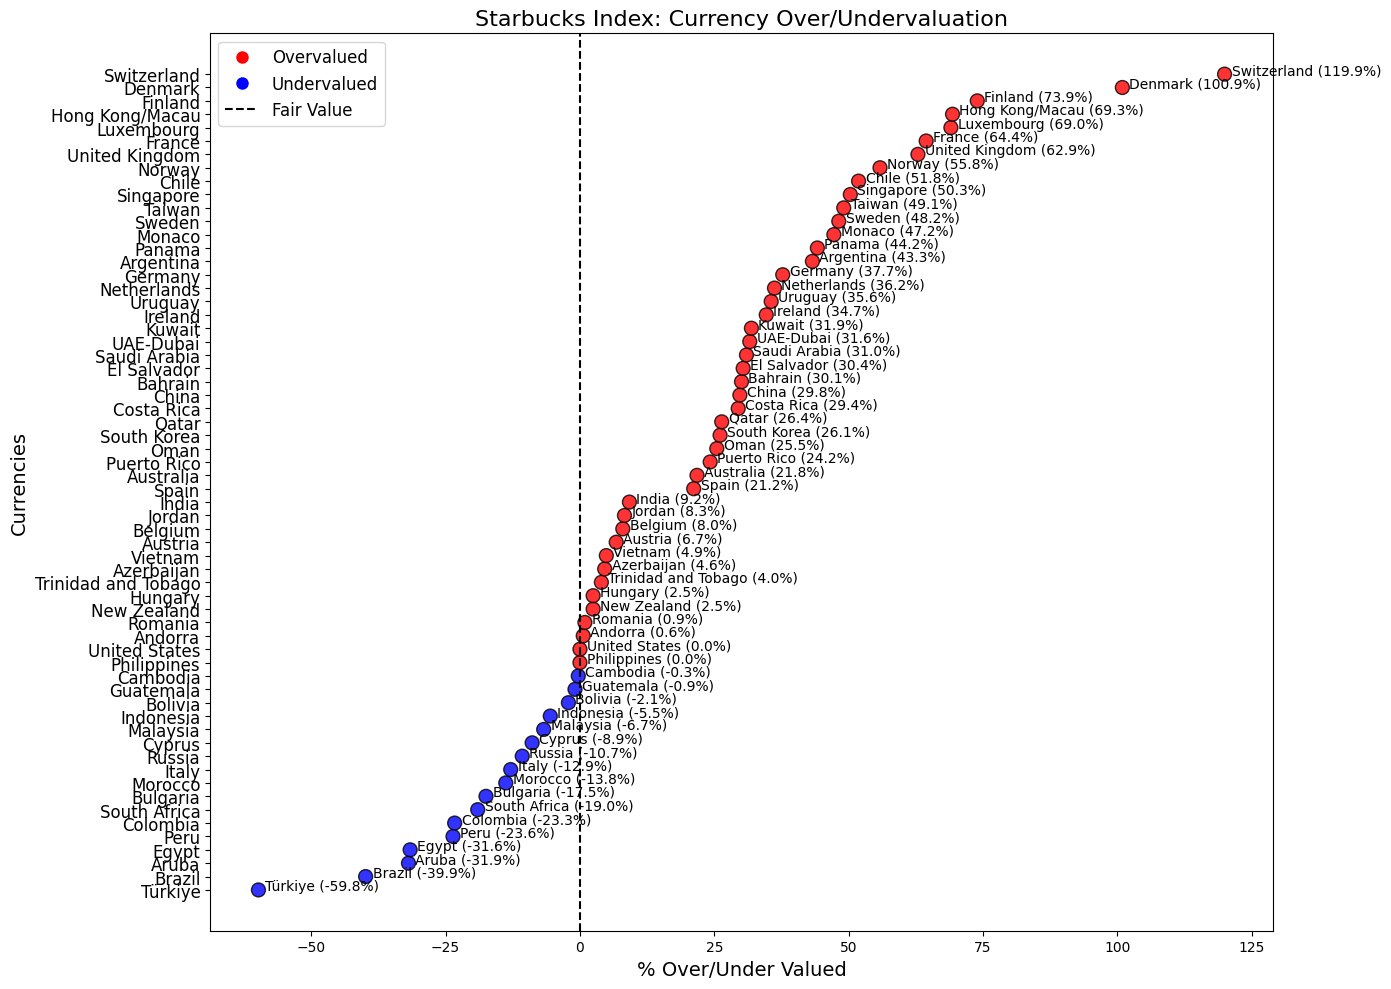

In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Define the Starbucks Index Data (latte prices in USD-terms)
# -------------------------------
starbucks_index = {
    "Türkiye": 1.31,
    "Brazil": 1.96,
    "Aruba": 2.22,
    "Egypt": 2.23,
    "Peru": 2.49,
    "Colombia": 2.50,
    "South Africa": 2.64,
    "Bulgaria": 2.69,
    "Morocco": 2.81,
    "Italy": 2.84,
    "Russia": 2.91,
    "Cyprus": 2.97,
    "Malaysia": 3.04,
    "Indonesia": 3.08,
    "Bolivia": 3.19,
    "Guatemala": 3.23,
    "Cambodia": 3.25,
    "Philippines": 3.26,
    "United States": 3.26,
    "Andorra": 3.28,
    "Romania": 3.29,
    "Hungary": 3.34,
    "New Zealand": 3.34,
    "Trinidad and Tobago": 3.39,
    "Azerbaijan": 3.41,
    "Vietnam": 3.42,
    "Austria": 3.48,
    "Belgium": 3.52,
    "Jordan": 3.53,
    "India": 3.56,
    "Spain": 3.95,
    "Australia": 3.97,
    "Puerto Rico": 4.05,
    "Oman": 4.09,
    "South Korea": 4.11,
    "Qatar": 4.12,
    "Costa Rica": 4.22,
    "China": 4.23,
    "Bahrain": 4.24,
    "El Salvador": 4.25,
    "Saudi Arabia": 4.27,
    "UAE-Dubai": 4.29,
    "Kuwait": 4.30,
    "Ireland": 4.39,
    "Uruguay": 4.42,
    "Netherlands": 4.44,
    "Germany": 4.49,
    "Argentina": 4.67,
    "Panama": 4.70,
    "Monaco": 4.80,
    "Sweden": 4.83,
    "Taiwan": 4.86,
    "Singapore": 4.90,
    "Chile": 4.95,
    "Norway": 5.08,
    "United Kingdom": 5.31,
    "France": 5.36,
    "Luxembourg": 5.51,
    "Hong Kong/Macau": 5.52,
    "Finland": 5.67,
    "Denmark": 6.55,
    "Switzerland": 7.17
}

# -------------------------------
# 2. Map Each Country to its Local Currency Code
# -------------------------------
currency_mapping = {
    "Türkiye": "TRY",
    "Brazil": "BRL",
    "Aruba": "AWG",
    "Egypt": "EGP",
    "Peru": "PEN",
    "Colombia": "COP",
    "South Africa": "ZAR",
    "Bulgaria": "BGN",
    "Morocco": "MAD",
    "Italy": "EUR",
    "Russia": "RUB",
    "Cyprus": "EUR",
    "Malaysia": "MYR",
    "Indonesia": "IDR",
    "Bolivia": "BOB",
    "Guatemala": "GTQ",
    "Cambodia": "KHR",
    "Philippines": "PHP",
    "United States": "USD",
    "Andorra": "EUR",
    "Romania": "RON",
    "Hungary": "HUF",
    "New Zealand": "NZD",
    "Trinidad and Tobago": "TTD",
    "Azerbaijan": "AZN",
    "Vietnam": "VND",
    "Austria": "EUR",
    "Belgium": "EUR",
    "Jordan": "JOD",
    "India": "INR",
    "Spain": "EUR",
    "Australia": "AUD",
    "Puerto Rico": "USD",
    "Oman": "OMR",
    "South Korea": "KRW",
    "Qatar": "QAR",
    "Costa Rica": "CRC",
    "China": "CNY",
    "Bahrain": "BHD",
    "El Salvador": "USD",
    "Saudi Arabia": "SAR",
    "UAE-Dubai": "AED",
    "Kuwait": "KWD",
    "Ireland": "EUR",
    "Uruguay": "UYU",
    "Netherlands": "EUR",
    "Germany": "EUR",
    "Argentina": "ARS",
    "Panama": "PAB",
    "Monaco": "EUR",
    "Sweden": "SEK",
    "Taiwan": "TWD",
    "Singapore": "SGD",
    "Chile": "CLP",
    "Norway": "NOK",
    "United Kingdom": "GBP",
    "France": "EUR",
    "Luxembourg": "EUR",
    "Hong Kong/Macau": "HKD",
    "Finland": "EUR",
    "Denmark": "DKK",
    "Switzerland": "CHF"
}

# The US latte price is our baseline.
us_price = starbucks_index["United States"]

# -------------------------------
# 3. Get Market Exchange Rates from the API
# -------------------------------
API_KEY = "6ca0dbdc07927154e65cb9f4"
API_URL = f"https://v6.exchangerate-api.com/v6/{API_KEY}/latest/USD"

try:
    response = requests.get(API_URL)
    response.raise_for_status()
    data = response.json()
except Exception as e:
    print("Error fetching exchange rates:", e)
    exit(1)

# The API may return the rates under "conversion_rates" or "rates"
if "conversion_rates" in data:
    rates = data["conversion_rates"]
elif "rates" in data:
    rates = data["rates"]
else:
    print("Unexpected API response structure.")
    exit(1)

# -------------------------------
# 4. Compute PPP-Adjusted Exchange Rates and Valuation Data
# -------------------------------
results = []

for country, index_price in starbucks_index.items():
    currency = currency_mapping.get(country)
    if not currency:
        print(f"Currency for {country} not specified, skipping.")
        continue
    if currency not in rates:
        print(f"Market rate for {country} (currency {currency}) not found, skipping.")
        continue

    market_rate = rates[currency]  # Market rate: local currency units per USD
    # Recover the local latte price:
    local_price = index_price * market_rate
    # Compute the PPP-adjusted exchange rate:
    ppp_rate = local_price / us_price
    # Compute the valuation percentage.
    # This will be negative if ppp_rate is below market_rate (undervalued)
    valuation_pct = ((ppp_rate - market_rate) / market_rate) * 100
    
    # Classify based on the sign of valuation_pct.
    if valuation_pct < 0:
        valuation_label = "Undervalued"
    elif valuation_pct > 0:
        valuation_label = "Overvalued"
    else:
        valuation_label = "Neutral"
    
    results.append({
        "Country": country,
        "Currency": currency,
        "Market Rate": market_rate,
        "PPP Exchange Rate (USD)": ppp_rate,
        "Valuation %": valuation_pct,
        "Currency Valuation": valuation_label
    })

# Convert results to a DataFrame and sort for visualization.
df = pd.DataFrame(results)
df_sorted = df.sort_values(by="Valuation %", ascending=True).reset_index(drop=True)

# -------------------------------
# 5. Prepare Data for Charting
# -------------------------------
# Define colors for the chart: blue for undervalued (negative %), red for overvalued (positive %)
df_sorted["Color"] = df_sorted["Currency Valuation"].apply(lambda x: "blue" if x == "Undervalued" else "red")

# -------------------------------
# 6. Create the Scatter Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(14, 10))

# Plot: x-axis is the Valuation %, y-axis uses the sorted order (each position corresponds to a country)
scatter = ax.scatter(df_sorted["Valuation %"], range(len(df_sorted)),
                     c=df_sorted["Color"], alpha=0.8, edgecolors="black", linewidths=1, s=100)

# Set y-axis ticks and labels (showing country names)
ax.set_yticks(range(len(df_sorted)))
ax.set_yticklabels(df_sorted["Country"], fontsize=12, ha="right")

# Annotate each point with the country name and valuation percentage.
for i, row in df_sorted.iterrows():
    percentage = round(row["Valuation %"], 1)
    ax.annotate(f"{row['Country']} ({percentage}%)",
                (row["Valuation %"], i),
                textcoords="offset points", xytext=(5, 0), ha="left", fontsize=10)

# Draw a vertical line at 0% to represent fair value.
ax.axvline(x=0, color="black", linestyle="--", linewidth=1.5, label="Fair Value")

# -------------------------------
# 7. Add Legend, Labels, and Title
# -------------------------------
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Overvalued',
               markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Undervalued',
               markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], color="black", linestyle="--", linewidth=1.5, label="Fair Value")
]

ax.legend(handles=handles, loc="upper left", fontsize=12)
ax.set_xlabel("% Over/Under Valued", fontsize=14)
ax.set_ylabel("Currencies", fontsize=14)
ax.set_title("Starbucks Index: Currency Over/Undervaluation", fontsize=16)

plt.tight_layout()
plt.show()